In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [3]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [4]:
# Import 'inspect' dependency
from sqlalchemy import inspect

In [5]:
# Iterate through 'Measurement' table to
# find names and types of columns
columns = inspect(engine).get_columns('Measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
# Get an idea what data in 'Measurement' looks like
engine.execute('SELECT * FROM Measurement LIMIT 7').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0)]

In [7]:
# Find total entries in 'Measurement'
total_dates = session.query(func.count(Measurement.date)).all()
print(f"Total entries in table is {total_dates}")

Total entries in table is [(19550,)]


In [8]:
#last data point in 'Measurement'
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)

print(f"The last date in the table is {last_date} and \n\
the date 1 year prior is {query_date}.")


The last date in the table is ('2017-08-23',) and 
the date 1 year prior is 2016-08-23.


In [9]:
# Make a general 'results' DataFrame from 
# 'Measurement' table
results = session.query(Measurement.date, \
                        Measurement.prcp, Measurement.tobs,
                        Measurement.station).all()

# Create DataFrame out of 'results'
results_df = pd.DataFrame(results[:], columns=['Date', 'Precipitation',
                                               'Temperature', 'Station'])

results_df.head()

,Date,Precipitation,Temperature,Station
0,2010-01-01,0.08,65.0,USC00519397
1,2010-01-02,0.00,63.0,USC00519397
2,2010-01-03,0.00,74.0,USC00519397
3,2010-01-04,0.00,76.0,USC00519397
4,2010-01-06,NaN,73.0,USC00519397


In [10]:
# Convert 'Date' from 'str' to 'datetime' format in df_date_prcp
# Order df_date_prcp by date and save into new DataFrame
order_dates_df = results_df.iloc\
                        [pd.to_datetime(results_df.Date).\
                         values.argsort()]

# Check length of date_ordered_prcp_df before cleaning
print(len(order_dates_df))
order_dates_df.head()

19550


,Date,Precipitation,Temperature,Station
0,2010-01-01,0.08,65.0,USC00519397
9007,2010-01-01,0.21,72.0,USC00518838
9518,2010-01-01,0.15,75.0,USC00519523
12187,2010-01-01,0.15,70.0,USC00519281
14959,2010-01-01,0.05,66.0,USC00511918


In [11]:
# Drop any rows with NaN
order_dates_df.dropna(inplace=True)

# Set index of order_dates_df to 'Date'
order_dates_df.set_index('Date', inplace=True)

# Print new length of cleaned date_ordered_prcp_df
print(f"New length of order_dates_df is {len(order_dates_df)}.")
order_dates_df.head(3)

New length of order_dates_df is 18103.


C:\Users\oimar\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Precipitation,Temperature,Station
Date,,,
2010-01-01,0.08,65.0,USC00519397
2010-01-01,0.21,72.0,USC00518838
2010-01-01,0.15,75.0,USC00519523


In [12]:
# Slice date_ordered_prcp_df by
# dates 2016-08-23 and 2017-08-23
ordered_2016_2017 = order_dates_df.\
loc['2016-08-23':'2017-08-23']

print(f"Length of ordered_prcp_2016_2017 is \
{len(ordered_2016_2017)}")

ordered_2016_2017.head()

Length of ordered_prcp_2016_2017 is 2021


,Precipitation,Temperature,Station
Date,,,
2016-08-23,0.00,81.0,USC00519397
2016-08-23,0.70,74.0,USC00516128
2016-08-23,1.79,77.0,USC00519281
2016-08-23,0.02,80.0,USC00519523
2016-08-23,0.15,76.0,USC00513117


In [13]:
# Drop 'temperature' and keep 'Date' and 'Precipitation' 
ordered_prcp_2016_2017 = ordered_2016_2017.drop(
                        labels=['Temperature', 'Station'], axis=1)

ordered_prcp_2016_2017.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.70
2016-08-23,1.79
2016-08-23,0.02
2016-08-23,0.15


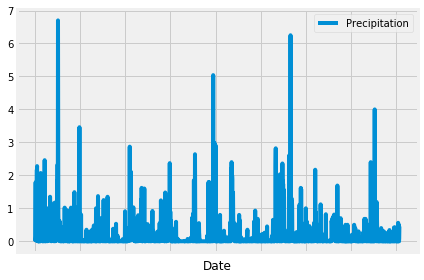

In [14]:
# Plot ordered_prcp_2016_2017
ordered_prcp_2016_2017.plot()
plt.xlim()
plt.tight_layout()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = pd.DataFrame(ordered_prcp_2016_2017['Precipitation'].describe())
summary

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# How many stations are available in this dataset?

In [16]:
# Iterate through 'Station' table to
# find names and types of columns
columns = inspect(engine).get_columns('Station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Get an idea what data in 'Station' looks like
engine.execute('SELECT * FROM Station LIMIT 2').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)]

In [18]:
# Find total entries in 'Station'
total = session.query(func.count(Station.name)).all()
print(f"Total entries in table is {total}")

Total entries in table is [(9,)]


# What are the most active stations? 

In [19]:
# Join 'Measurement' stats with name of stations from 'Station'
names_stations = engine.execute('SELECT s.name, m.station, m.tobs, m.prcp\
                FROM Measurement as m\
                INNER JOIN Station as s\
                ON m.station = s.station;').fetchall()

In [20]:
# Create DataFrame out of yr2010_dat_prcp query
station_readings = pd.DataFrame(names_stations[:], 
                                   columns=['Station Name', 
                                            'Total Readings',
                                            'Avg Temperature',
                                            'Total Rainfall'])

# Group readings by 'Station Name' and sort by 'Total Readings'
station_readings_grp = station_readings.groupby(['Station Name']).count().\
                        sort_values(by='Total Readings', ascending=False)

# Drop 'Avg Temperature' and 'Total Rainfall' column
station_readings_grp.drop(labels=['Avg Temperature', 'Total Rainfall'],
                          axis=1, inplace=True)

# Show grouped station readings DataFrame
station_readings_grp


,Total Readings
Station Name,
"WAIHEE 837.5, HI US",2772
"WAIKIKI 717.2, HI US",2724
"KANEOHE 838.1, HI US",2709
"WAIMANALO EXPERIMENTAL FARM, HI US",2669
"MANOA LYON ARBO 785.2, HI US",2612
"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
"HONOLULU OBSERVATORY 702.2, HI US",1979
"PEARL CITY, HI US",1372
"UPPER WAHIAWA 874.3, HI US",511


# What are the lowest and highest recorded temperatures?

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Create query for from 'Measurement' for temperature and group by station
temperature_all = session.query(Measurement.station, Measurement.tobs).all()

In [22]:
# Create pandas DataFrame from 'temperature_all'
temperature_df = pd.DataFrame(temperature_all[:], columns=['Station Code', 'Temperature'])

# Group by 'Station ID' to find min temperature
# in ascending order
min_temp_df = temperature_df.groupby('Station Code').min().sort_values(by='Temperature', ascending=True)

# Reset index, so 'Station ID' becomes column
min_temp_df.reset_index(inplace=True)

# Chceck min_temp_df
min_temp_df

# Save min temp and station with min temp into separate variables
min_temp = min_temp_df['Temperature'][0]
min_temp_station = min_temp_df['Station Code'][0]


# Print min temp and station with min temp
print(f"The lowest temperature, {min_temp}, was recoreded at {min_temp_station}.")

The lowest temperature, 53.0, was recoreded at USC00511918.


In [23]:
# Group by 'Station ID' to find max temperature
# in descending order
max_temp_df = temperature_df.groupby('Station Code').max().sort_values(by='Temperature', ascending=False)

# Reset index, so 'Station ID' becomes column
max_temp_df.reset_index(inplace=True)

# Chceck min_temp_df
max_temp_df

# Save min temp and station with min temp into separate variables
max_temp = max_temp_df['Temperature'][0]
max_temp_station = max_temp_df['Station Code'][0]


# Print min temp and station with min temp
print(f"The highest temperature, {max_temp}, was recoreded at {max_temp_station}.")

The highest temperature, 87.0, was recoreded at USC00511918.


# What's the average temperature of the station with the most readings?

In [24]:
# Select station name and station code from 'Station'
station_all = engine.execute('SELECT name, station, latitude,\
                                    longitude, elevation\
                                    FROM Station;').fetchall()

# Make station_all a pd DataFrame
station_all_df = pd.DataFrame(station_all[:], 
                                    columns=['Station Name', 'Station Code',
                                             'Latitude','Longitude',
                                             'Elevation'])
# Set station_all_df index to 'Station Name'
station_all_df.set_index('Station Name', inplace=True)
station_all_df.head(1)

,Station Code,Latitude,Longitude,Elevation
Station Name,,,,
"WAIKIKI 717.2, HI US",USC00519397,21.2716,-157.8168,3.0


In [25]:
# Group readings by 'Station Name' and find mean temp for each station
station_avg_temp_grp = station_readings.groupby(['Station Name']).mean()

# Check newly grouped df
station_avg_temp_grp.head(1)

,Avg Temperature,Total Rainfall
Station Name,,
"HONOLULU OBSERVATORY 702.2, HI US",71.615968,0.047971


In [26]:
# Join station_readings_grp with station_name_num_df
station_readings_code = station_avg_temp_grp.join(station_all_df,on='Station Name')

# Check newly joined df
station_readings_code.head(1)

,Avg Temperature,Total Rainfall,Station Code,Latitude,Longitude,Elevation
Station Name,,,,,,
"HONOLULU OBSERVATORY 702.2, HI US",71.615968,0.047971,USC00511918,21.3152,-157.9992,0.9


In [27]:
# Drop 'Avg Temperature' and 'Total Rainfall' column
station_readings_code.drop(labels=['Total Rainfall', 'Station Code',
                                      'Latitude', 'Longitude',
                                      'Elevation'], axis=1, inplace=True)

station_readings_code.head(1)

,Avg Temperature
Station Name,
"HONOLULU OBSERVATORY 702.2, HI US",71.615968


In [28]:
# Join with 'Total Readings' from df station_readings_grp
station_readings_avgTemp = station_readings_code.join(
station_readings_grp, on="Station Name").sort_values('Total Readings', ascending=False)

# Reset Index of table
station_readings_avgTemp.reset_index(inplace=True)

# Make variables to find avg temp of station with most readings
most_readings_station = station_readings_avgTemp['Station Name'][0]
most_readings_avgTemp = station_readings_avgTemp['Avg Temperature'][0]
most_readings_num = station_readings_avgTemp['Total Readings'][0]

print(f"{most_readings_station} is the station with the most temperature  \
readings at a total of {most_readings_num} readings and an \
average temperature reading of {most_readings_avgTemp} F.")

station_readings_avgTemp

WAIHEE 837.5, HI US is the station with the most temperature  readings at a total of 2772 readings and an average temperature reading of 71.66378066378067 F.


,Station Name,Avg Temperature,Total Readings
0,"WAIHEE 837.5, HI US",71.663781,2772
1,"WAIKIKI 717.2, HI US",74.553231,2724
2,"KANEOHE 838.1, HI US",72.689184,2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",74.543649,2669
4,"MANOA LYON ARBO 785.2, HI US",70.915008,2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",74.873297,2202
6,"HONOLULU OBSERVATORY 702.2, HI US",71.615968,1979
7,"PEARL CITY, HI US",74.684402,1372
8,"UPPER WAHIAWA 874.3, HI US",72.724070,511


# Past 12 Months of Temperature data for WAIHEE (Station with highest number of temperature observations)

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
# and plot the results as a histogram

In [30]:
# Use ordered_2016_2017 from earlier to create a
# DataFrame with 'Date' and 'Temperature'
ordered_temp_2016_2017 = ordered_2016_2017.\
                        drop(labels=['Precipitation'],axis=1)

# Set index to 'Station' in order to loc on Waihee Station
df_date_temp = ordered_temp_2016_2017.set_index('Station')
waihee_temp_df = df_date_temp.loc['USC00519281']

waihee_temp_df.head()

,Temperature
Station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


In [31]:
# Now only just waihee, reset index and drop 'Station' row
waihee_temp_df.reset_index(inplace=True)
waihee_temp_df.drop(labels=['Station'], axis=1, inplace=True)
waihee_temp_df.rename(columns={'Temperature': 'Tobs'}, inplace=True)

waihee_temp_df.head()

C:\Users\oimar\Miniconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\oimar\Miniconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


In [32]:
# Create bins for temperature groups
bins = [59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81]

waihee_temp_df['Temp Groups'] = pd.cut(waihee_temp_df['Tobs'], bins)
waihee_temp_grp = waihee_temp_df.groupby('Temp Groups').count()
waihee_temp_grp.reset_index(inplace=True)
waihee_temp_grp

C:\Users\oimar\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Temp Groups,Tobs
0,"(59, 61]",3
1,"(61, 63]",10
2,"(63, 65]",10
3,"(65, 67]",20
4,"(67, 69]",31
5,"(69, 71]",40
6,"(71, 73]",40
7,"(73, 75]",72
8,"(75, 77]",64
9,"(77, 79]",40


Text(0.5, 1.0, 'Frequency of Temperatures at Waihee Station')

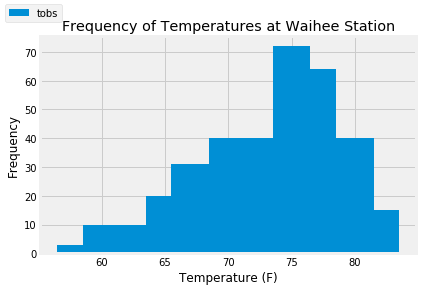

In [33]:
# Create squished bar chart of frequency of temperature
# readings from Waihee Station
x = [58, 60, 63, 65, 67, 70, 73, 75, 77, 80, 82]
y = waihee_temp_grp['Tobs']

plt.bar(x,y, width=3)
plt.figlegend(['tobs'], loc='upper left')
plt.ylabel('Frequency')
plt.xlabel('Temperature (F)')
plt.title('Frequency of Temperatures at Waihee Station')

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Previous year dates used: 2016-08-23 to 2017-08-23
temp_2011 = calc_temps('2011-02-28','2011-03-05')
print(calc_temps('2011-02-28','2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


Text(0, 0.5, 'Temp (F)')

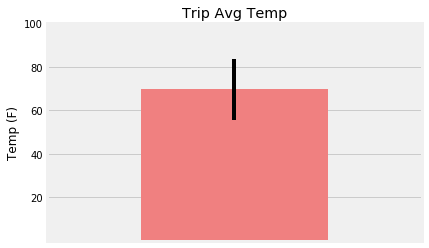

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Make calc temp result into pd DataFrame
calc_temp_2011 = pd.DataFrame(temp_2011[:],
                                  columns=['Min Temp',
                                           'Avg Temp',
                                           'Max Temp'])


# Plot calc_temp_2010_2011 as bar chart
min_temp = calc_temp_2011['Min Temp'][0]
max_temp = calc_temp_2011['Max Temp'][0]
avg_temp = calc_temp_2011['Avg Temp'][0]

calc_temp_2011['Avg Temp'].plot(kind='bar', title="Trip Avg Temp",
                                    yerr=max_temp-min_temp,
                                    color='lightcoral')

plt.xticks(ticks=[])
plt.yticks(ticks=[20,40,60,80,100])
plt.ylabel('Temp (F)')


In [37]:
# Calculate the rainfall per weather station for your trip dates 
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount and 
# list the station, name, latitude, longitude, and elevation

# Group readings by 'Station Name' and sort by 'Total Readings'
station_prcp_total = station_readings.groupby(['Station Name']).sum().\
                        sort_values(by='Total Rainfall', ascending=False)

# Drop 'Avg Temperature'column
station_prcp_total.drop(labels=['Avg Temperature'], axis=1, inplace=True)

station_prcp_total

,Total Rainfall
Station Name,
"MANOA LYON ARBO 785.2, HI US",1068.09
"WAIHEE 837.5, HI US",588.64
"KANEOHE 838.1, HI US",382.62
"WAIMANALO EXPERIMENTAL FARM, HI US",295.68
"KUALOA RANCH HEADQUARTERS 886.9, HI US",234.49
"WAIKIKI 717.2, HI US",131.62
"HONOLULU OBSERVATORY 702.2, HI US",92.68
"UPPER WAHIAWA 874.3, HI US",70.87
"PEARL CITY, HI US",43.44


In [38]:
# Check the DataFrame station_all_df
# Remember what the columns are
station_all_df.head()

,Station Code,Latitude,Longitude,Elevation
Station Name,,,,
"WAIKIKI 717.2, HI US",USC00519397,21.2716,-157.8168,3.0
"KANEOHE 838.1, HI US",USC00513117,21.4234,-157.8015,14.6
"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,21.5213,-157.8374,7.0
"PEARL CITY, HI US",USC00517948,21.3934,-157.9751,11.9
"UPPER WAHIAWA 874.3, HI US",USC00518838,21.4992,-158.0111,306.6


In [39]:
# Join 'station_prcp_total' with info from 'station_all_df'
station_rainfall_combo = station_prcp_total.join(station_all_df, on='Station Name', how='outer')

station_rainfall_combo

,Total Rainfall,Station Code,Latitude,Longitude,Elevation
Station Name,,,,,
"MANOA LYON ARBO 785.2, HI US",1068.09,USC00516128,21.33310,-157.80250,152.4
"WAIHEE 837.5, HI US",588.64,USC00519281,21.45167,-157.84889,32.9
"KANEOHE 838.1, HI US",382.62,USC00513117,21.42340,-157.80150,14.6
"WAIMANALO EXPERIMENTAL FARM, HI US",295.68,USC00519523,21.33556,-157.71139,19.5
"KUALOA RANCH HEADQUARTERS 886.9, HI US",234.49,USC00514830,21.52130,-157.83740,7.0
"WAIKIKI 717.2, HI US",131.62,USC00519397,21.27160,-157.81680,3.0
"HONOLULU OBSERVATORY 702.2, HI US",92.68,USC00511918,21.31520,-157.99920,0.9
"UPPER WAHIAWA 874.3, HI US",70.87,USC00518838,21.49920,-158.01110,306.6
"PEARL CITY, HI US",43.44,USC00517948,21.39340,-157.97510,11.9
